In [1]:
# Will Hollingsworth, Colton Murray, Alexander Shiveley

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Getting the data into Python

In [3]:
# Load the csv as a numpy array of strings, 
# because it includes the column headers
raw_data = np.loadtxt('iris.csv', delimiter=',', dtype=str)

# Grab the headers
header_list = raw_data[0].tolist()

# Remove the headers from the data
stripped = np.delete(raw_data, [0], axis=0)

# We specifically want to know if a sample is setosa or NOT setosa
def apply_mapping(row):
    row[4] = 1 if row[4] == 'setosa' else 0
    return row

# Convert species to a numeric value
converted = np.apply_along_axis(apply_mapping, 1, stripped)

# Convert everything into floats!
clean_data = np.array(converted, dtype=float)

In [4]:
def split_input_output(data):
    """
    Splits the input array into two seperate sets:
        * the feature values
        * the output value
        
    :returns: (tuple) the features are the first element, the outputs are the second
    """
    return np.delete(data, [data.shape[1] - 1], axis=1), data[:, -1]

In [5]:
# we also probably want to be able to separate our positive and negative examples
def split_pos_neg(data):
    """
    Returns two sets of positive, then negative examples (1's then 0's from the output column)
    """
    return data[data[:, -1]==1, :-1], data[data[:, -1]==0, :-1]

In [6]:
pos, neg = split_pos_neg(clean_data)

# Histograms

In [7]:
def get_range(data, attribute):
    return data[:, attribute].min(), data[:, attribute].max()

def get_bin_edges(data, attribute, num_bins):
    l, h = get_range(data, attribute)
    
    step = (h - l) / num_bins
    edges = np.arange(num_bins + 1)
    return (edges * step) + l

def hist(data, attribute, num_bins):
    """
    Produces two histograms, one for positive and one for negative examples.
    Calculates the bins from the entire data set.
    
    :param data: The TOTAL data set
    :attribute: the attribute (column index) you'd like to histogram
    :num_bins: the number of bins for the histogram
    """
    edges = get_bin_edges(data, attribute, num_bins)
    pos, neg = split_pos_neg(data)
    
    h_pos, _ = np.histogram(pos[:, attribute], edges)
    h_neg, _ = np.histogram(neg[:, attribute], edges)
    
    return h_pos, h_neg, edges
    

In [8]:
h_pos, h_neg, e = hist(clean_data, 2, 5)
h_pos, h_neg, e

(array([50,  0,  0,  0,  0], dtype=int64),
 array([ 0,  3, 34, 47, 16], dtype=int64),
 array([1.  , 2.18, 3.36, 4.54, 5.72, 6.9 ]))

In [9]:
# ^ Notice how they're completely separate for petal length

# Entropy

In [10]:
def total_entropy(data_set):
    """
    Calculates the entropy of a data set.
    Assumes that the final column is the classification for each sample.
    """
    x, y = split_input_output(data_set)
    
    # get the possible output values, and their totals
    values, counts = np.unique(y, return_counts=True)
    entropy = 0
    for count in counts:
        p = count / sum(counts)   
        entropy -= p * math.log(p, 2)
        # Alex - I know the base should be len(values), but in most cases this is 2 for this assignment.
        # It caused issues for me in ID3 if len(values) was 1
        
    return entropy

def bucket_entropy(pos_count, neg_count):
    if pos_count == 0 or neg_count == 0:
        return 0
    
    p = pos_count / (pos_count + neg_count)
    return -p * math.log(p, 2)


def info_gained(data_set, attribute, num_bins):
    h_pos, h_neg, _ = hist(data_set, attribute, num_bins)
    
    tot_entropy = total_entropy(data_set)
    for i in range(len(h_pos)):
        bin_size_ratio = (h_pos[i] + h_neg[i]) / data_set.shape[0]
        tot_entropy -= bin_size_ratio * bucket_entropy(h_pos[i], h_neg[i])
        
    return tot_entropy

In [11]:
total_entropy(clean_data)

0.9182958340544896

In [12]:
info_gained(clean_data, 2, 5)

0.9182958340544896

# ID3

In [13]:
def in_range(value, val_range):
    return value >= val_range[0] and value < val_range[1]

def filter_data(data_set, attribute, val_range):
    rows = []
    for row in range(data_set.shape[0]):
            if in_range(data_set[row, attribute], val_range):
                rows.append(row)
    return data_set[rows, :]

def id3_generate_tree(data_set, num_bins, decision_tree=None, used_attr=None):
    """
    Recursively produces an ID3 tree based on the data set and number of bins.
    
    :param data_set: The TOTAL data set for this node or entire tree
    :num_bins: the number of bins for the histogram
    :decision_tree: the subtree to expand
    :used_attr: list of used attributes so far down this branch
    """     
    # Start with a root node if tree is empty
    if decision_tree is None:
        decision_tree = {"attribute": None, "range": None, "children": [], "split": None}
    # Start with empty list of used attributes
    if used_attr is None:
        used_attr = []    
    
    # Find the attribute with the highest information gain, if the attribute is unused
    best_attr = None
    for attr in range(0, data_set.shape[1] - 1):
        if not attr in used_attr:
            if best_attr is None or info_gained(data_set, attr, num_bins) > info_gained(data_set, best_attr, num_bins):
                best_attr = attr
    if best_attr is not None:
        decision_tree["attribute"] = best_attr
        used_attr.append(best_attr)
    
    # Get the histograms for the best attribute and the edges
    h_pos, h_neg, e = hist(data_set, best_attr, num_bins)
    # Add a node to the tree for each bin
    for i in range(len(h_pos)):  
        child = {}
        # The range of the best attribute for this bin. Allow for bounds to infinities on ends of histogram
        val_range = (e[i] if i > 0 else float('-inf'), e[i + 1] if i < len(h_pos) - 1 else float('inf'))
        
        # If the bin is all positive, all negative, empty?, or there are no unused attributes left, create a leaf node
        if h_pos[i] > 0 and h_neg[i] == 0 or h_pos[i] == 0 and h_neg[i] > 0 or h_pos[i] == 0 or best_attr == None:
            split = (h_pos[i], h_neg[i])
            child = {"attribute": None, "range": val_range, "children": [], "split": split}      
        # Else expand the bin using the filtered dataset for that bin    
        else:
            child = id3_generate_tree(filter_data(data_set, best_attr, val_range), num_bins, {"attribute": None, "range": val_range, "children": [], "split": None}, used_attr.copy())
        
        decision_tree["children"].append(child)
    return decision_tree

def id3_range_str(val_range):
    """
    Print the range, accounting for infinities
    """
    if val_range[0] == float('-inf'):
        return "<  " + str(val_range[1])
    if val_range[1] == float('inf'):
        return ">= " + str(val_range[0])
    return "in [" + str(val_range[0]) + ", " + str(val_range[1]) + ")"

def id3_print_tree(tree, depth = 0):
    for child in tree["children"]:        
        print("    " * depth, "Attribute", tree["attribute"], id3_range_str(child["range"]), ": " + str(child["split"]) if child["split"] != None else "")
        id3_print_tree(child, depth + 1)

In [14]:
def id3_p(x, decision_tree):
    """
    Get the probability for the point being classified positive by the tree
    """
    node = decision_tree
    while node["split"] is None:
        for child in node["children"]:   
            if in_range(x[node["attribute"]], child["range"]):
                node = child
                break
    # return Num Pos / (Num Pos + Num Neg) or 0 if empty
    return (node["split"][0] / (node["split"][0] + node["split"][1])) if (node["split"][0] + node["split"][1]) > 0 else 0

def id3_classify(x_data_set, decision_tree):
    """
    Classify y values for the data set using a decision tree
    
    :param x_data_set: The x part of the data set
    :decision_tree: the tree to classify each point
    """     
    y_matrix = np.empty((x_data_set.shape[0], 1))
    for row in range(x_data_set.shape[0]):
        y_matrix[row, 0] = id3_p(x_data_set[row, :], decision_tree)
    return y_matrix

In [15]:
id3_tree = id3_generate_tree(clean_data, 2)
id3_print_tree(id3_tree)

 Attribute 2 <  3.95 
     Attribute 3 <  0.7499999999999999 : (50, 0)
     Attribute 3 >= 0.7499999999999999 : (0, 11)
 Attribute 2 >= 3.95 : (0, 89)


In [16]:
def get_sets(data, split):
    """
    Convenience function that randomly selects a training and test set from the input data.
    
    :param data: (ndarray) the data you want to split
    :param split: (float) the percentage of the data you want to be TRAINING data
    
    :returns: (tuple) a tuple where the first element is the training set, and the second element is the test set
    """
    # Randomly shuffle the order from a copy of the data
    shuffled = data.copy()
    np.random.shuffle(shuffled)

    row_count = data.shape[0]

    # calc the number of samples, assumes the input samples are seperated by row
    training_count = round(row_count * split)
    
    training_set = shuffled[:training_count]
    test_set = shuffled[training_count:]
    
    return training_set, test_set

# Classification Metrics
Define functions for accuracy, precision, recall, f1 score, and roc curves.
Tested on ID3 and later used for ID3 and Naive Bayes runs.

In [17]:
def accuracy(classified, test):
    comp = (classified[:, -1] == test[:, -1])
    return np.count_nonzero(comp) / len(comp)

In [18]:
def precision(classified, test):
    tp_comp = np.logical_and(classified[:, -1] == 1, test[:, -1] == 1)
    p_comp = (classified[:, -1] == 1)
    return np.count_nonzero(tp_comp) / np.count_nonzero(p_comp)

In [19]:
def recall(classified, test):
    tp_comp = np.logical_and(classified[:, -1] == 1, test[:, -1] == 1)
    fn_comp = np.logical_and(classified[:, -1] == 0, test[:, -1] == 1)
    return np.count_nonzero(tp_comp) / (np.count_nonzero(tp_comp) + np.count_nonzero(fn_comp))

In [20]:
def f1_score(classified, test):
    p = precision(classified, test)
    r = recall(classified, test)
    return (2 * p * r) / (p + r)

In [21]:
def roc(test, p_fn, y_classified):
    points_x = []
    points_y = []
    pos_examples, neg_examples = split_pos_neg(test)
    for t in np.arange(1, -.01, -.01):
        fp = 0
        tp = 0
        """
        for row in range(test.shape[0]):
            if p_fn(test[row, :]) >= t:                
                if y_classified[row] == 1:
                    tp = tp + 1
                else:
                    fp = fp + 1
        """
        for example in test:
            if p_fn(example) >= t:   
                if example[-1] == 1:
                    tp = tp + 1
                else:
                    fp = fp + 1
        pos = np.count_nonzero(y_classified)
        neg = y_classified.shape[0] - pos
        tpr = tp / len(pos_examples)
        fpr = fp / len(neg_examples)
        points_x.append(fpr)
        points_y.append(tpr)
    return points_x, points_y

# Naive Bayes

In [22]:
from collections import namedtuple
nb_learn_output = namedtuple('nb_learn_output', ['est_pr_pos', 'est_pr_neg', 'attr_pr_given_pos', 'attr_pr_given_neg'])

def nb_learn(data_set, num_bins):
    pos_examples, neg_examples = split_pos_neg(data_set)
    
    # Count positive / negative examples
    pos_count = len(pos_examples)
    neg_count = len(neg_examples)
    
    # Estimate probabilities of positive and negative classification
    est_pr_pos = pos_count / (neg_count + pos_count)
    est_pr_neg = neg_count / (neg_count + pos_count)
    
    # Result dictionary
    # structured as Attribute index -> bin range -> probability
    # {1: {(2., 2.48): 1/50, ...}, 2: {(1., 2.18): 50/50, ...}, ...}
    attr_pr_given_pos = {}
    attr_pr_given_neg = {}
    
    for attribute in range(neg_examples.shape[1]):
        # Setup dictionary for results; maps bin range -> probability
        attr_pr_given_neg[attribute] = {}
        attr_pr_given_pos[attribute] = {}
        
        # Perform the histogram'ing for this attribute
        pos, neg, e = hist(data_set, attribute, num_bins)
    
        # Calc probability that pos/neg examples have this attribute value for each bin
        for bindex in range(num_bins):
            attr_pr_given_neg[attribute][(e[bindex], e[bindex+1])] = neg[bindex] / neg_count
            attr_pr_given_pos[attribute][(e[bindex], e[bindex+1])] = pos[bindex] / pos_count
            
    return nb_learn_output(est_pr_pos, est_pr_neg, attr_pr_given_pos, attr_pr_given_neg)

In [23]:
def nb_p(example, learn_output):
    """
    Get the probability for the point being classified positive by the training
    """
    # Calc the probability that this is a positive example
    pr_pos = learn_output.est_pr_pos
    for attribute in range(len(example) - 1):
        for bin_range in learn_output.attr_pr_given_pos[attribute]:
            if in_range(example[attribute], bin_range):
                pr_pos *= learn_output.attr_pr_given_pos[attribute][bin_range]
                break

    # Calc the probability that this is a negative example
    pr_neg = learn_output.est_pr_neg
    for attribute in range(len(example) - 1):
        for bin_range in learn_output.attr_pr_given_neg[attribute]:
            if in_range(example[attribute], bin_range):
                pr_neg *= learn_output.attr_pr_given_neg[attribute][bin_range]
                break    
    
    # Normalize the probabilities to be out of 1
    pr_normalized = 0 if (pr_pos + pr_neg) == 0 else pr_pos / (pr_pos + pr_neg)
    return pr_normalized

def nb_classify(data_set, learn_output):
    classified = []
    
    for example in data_set:                    
        # Classify the example
        if nb_p(example, learn_output) > 0.5:
            classified.append(np.array([1]))
        else:
            classified.append(np.array([0]))
        
    return np.array(classified)
        

# ID3 and Naive Bayes Runs

In [24]:
# Convenience function to run all of the id3 and naive bayes trials
def run_trials(data, learn_lambda, classify_lambda, roc_p_func):
    
    accs = {}
    f1s = {}
    rocs = {}
    for bins in range(5, 25, 5):
        accs[bins] = []
        f1s[bins] = []
        sets = [get_sets(data, 2/3), get_sets(data, 2/3), get_sets(clean_data, 2/3), get_sets(data, 2/3), get_sets(data, 2/3)]
        for s in sets:
            o = learn_lambda(s[0], bins)
            c = classify_lambda(s[1], o)
            accs[bins].append(accuracy(c, s[1]))
            f1s[bins].append(f1_score(c, s[1])) 
            rocs[bins] = roc(s[1], lambda x: roc_p_func(x, o), c)
            
    for b in accs:
        print(f"Bins: {b}")
        print(f"\tAccuracies: {accs[b]}")
        print(f"\tMin Acc: {min(accs[b])}")
        print(f"\tMax Acc: {max(accs[b])}")
        print(f"\tAvg Acc: {np.average(accs[b])}")
        
    x = np.arange(1, 6, 1)
    plt.plot(x, accs[5], '--r', label='Accuracy Bins: 5')
    plt.plot(x, accs[10], '--g', label='Accuracy Bins: 10')
    plt.plot(x, accs[15], '--b', label='Accuracy Bins: 15')
    plt.plot(x, accs[20], '--y', label='Accuracy Bins: 20')
    plt.legend()
    plt.ylim((.5, 1.1)) 
    plt.xlabel("Trial")
    plt.ylabel("Accuracy")
    plt.title("Accuracies Across Trials")
    plt.xticks(x)
    plt.show()   
        
    x = np.arange(1, 6, 1)
    plt.plot(x, f1s[5], '--r', label='F1 Score Bins: 5')
    plt.plot(x, f1s[10], '--g', label='F1 Score Bins: 10')
    plt.plot(x, f1s[15], '--b', label='F1 Score Bins: 15')
    plt.plot(x, f1s[20], '--y', label='F1 Score Bins: 20')
    plt.legend()
    plt.ylim((.5, 1.1)) 
    plt.xlabel("Trial")
    plt.ylabel("Score")
    plt.title("F1 Scores Across Trials")
    plt.xticks(x)
    plt.show()    
    
    if roc_p_func is not None:
        plt.plot(rocs[5][0], rocs[5][1], '--ro', label='ROC Curve Bins: 5')
        plt.plot(rocs[10][0], rocs[10][1], '--go', label='ROC Curve Bins: 10')
        plt.plot(rocs[15][0], rocs[15][1], '--bo', label='ROC Curve Bins: 15')
        plt.plot(rocs[20][0], rocs[20][1], '--yo', label='ROC Curve Bins: 20')
        plt.legend()
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title("ROC Curves")
        plt.xlim((-.1, 1.1)) 
        plt.ylim((-.1, 1.1)) 
        plt.show()

Bins: 5
	Accuracies: [1.0, 1.0, 1.0, 1.0, 1.0]
	Min Acc: 1.0
	Max Acc: 1.0
	Avg Acc: 1.0
Bins: 10
	Accuracies: [1.0, 1.0, 1.0, 1.0, 1.0]
	Min Acc: 1.0
	Max Acc: 1.0
	Avg Acc: 1.0
Bins: 15
	Accuracies: [1.0, 1.0, 1.0, 1.0, 1.0]
	Min Acc: 1.0
	Max Acc: 1.0
	Avg Acc: 1.0
Bins: 20
	Accuracies: [1.0, 1.0, 1.0, 1.0, 1.0]
	Min Acc: 1.0
	Max Acc: 1.0
	Avg Acc: 1.0


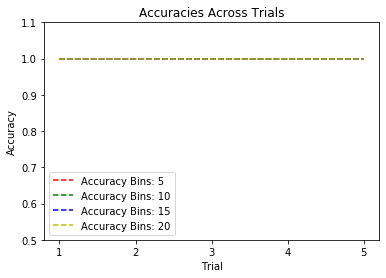

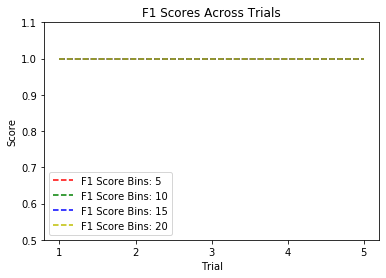

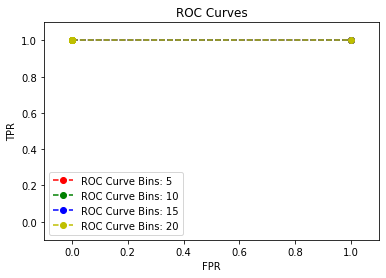

In [25]:
id3_l = lambda train, bins: id3_generate_tree(train, bins)
id3_c = lambda test, tree: id3_classify(test, tree)

run_trials(clean_data, id3_l, id3_c, id3_p)

Bins: 5
	Accuracies: [1.0, 0.98, 0.98, 0.96, 1.0]
	Min Acc: 0.96
	Max Acc: 1.0
	Avg Acc: 0.984
Bins: 10
	Accuracies: [0.98, 0.96, 0.98, 0.98, 0.96]
	Min Acc: 0.96
	Max Acc: 0.98
	Avg Acc: 0.9719999999999999
Bins: 15
	Accuracies: [1.0, 0.96, 0.98, 0.96, 0.96]
	Min Acc: 0.96
	Max Acc: 1.0
	Avg Acc: 0.9719999999999999
Bins: 20
	Accuracies: [0.94, 0.98, 0.96, 0.94, 0.94]
	Min Acc: 0.94
	Max Acc: 0.98
	Avg Acc: 0.952


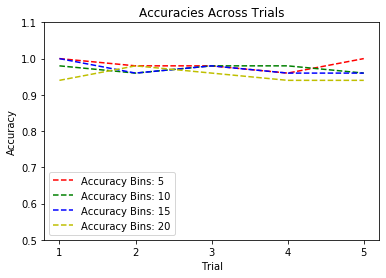

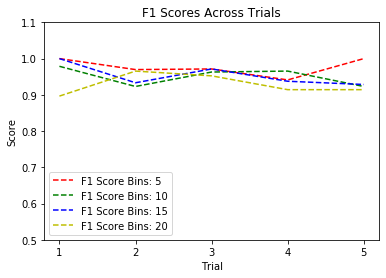

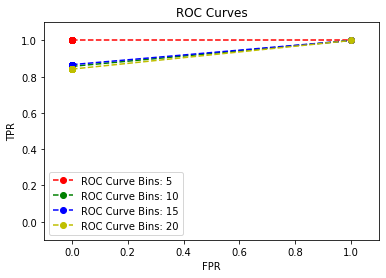

In [26]:
nb_l = lambda train, bins: nb_learn(train, bins)
nb_c = lambda test, nb_o: nb_classify(test, nb_o)

run_trials(clean_data, nb_l, nb_c, nb_p)

In [27]:
# Convenience function to run all of the id3 and naive bayes trials where one is a ground truth for the other
def run_trials_ground_truth(data, truth_learn_lambda, truth_classify_lambda, other_learn_lambda, other_classify_lambda, title):
    
    f1s = {}
    for bins in range(5, 25, 5):
        f1s[bins] = []
        sets = [get_sets(data, 2/3), get_sets(data, 2/3), get_sets(clean_data, 2/3), get_sets(data, 2/3), get_sets(data, 2/3)]
        y_preds = []
        # Get the ground truth classifications
        for s in sets:
            o = truth_learn_lambda(s[0], bins)
            c = truth_classify_lambda(s[1], o)
            y_preds.append(c)
        
        # Run the next algorithm against ground truth
        for i in range(len(sets)):
            s = sets[i]
            o = truth_learn_lambda(s[0], bins)
            c = truth_classify_lambda(s[1], o)
            f1s[bins].append(f1_score(c, y_preds[i])) 
        
    x = np.arange(1, 6, 1)
    plt.plot(x, f1s[5], '--r', label='F1 Score Bins: 5')
    plt.plot(x, f1s[10], '--g', label='F1 Score Bins: 10')
    plt.plot(x, f1s[15], '--b', label='F1 Score Bins: 15')
    plt.plot(x, f1s[20], '--y', label='F1 Score Bins: 20')
    plt.legend()
    plt.ylim((.5, 1.1)) 
    plt.xlabel("Trial")
    plt.ylabel("Score")
    plt.title(title)
    plt.xticks(x)
    plt.show()

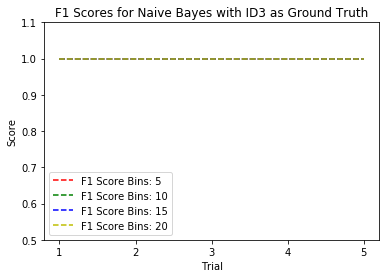

In [28]:
# Naive Bayes with ID3 as ground truth
run_trials_ground_truth(clean_data, id3_l, id3_c, nb_l, nb_c, "F1 Scores for Naive Bayes with ID3 as Ground Truth")

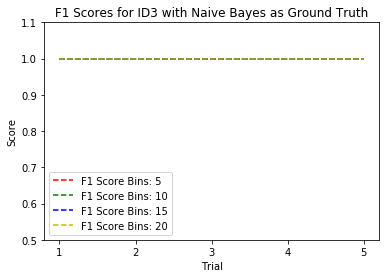

In [29]:
# ID3 with Naive Bayes as ground truth
run_trials_ground_truth(clean_data, nb_l, nb_c, id3_l, id3_c, "F1 Scores for ID3 with Naive Bayes as Ground Truth")